<a href="https://colab.research.google.com/github/YujinCHACHA/DNA_test1/blob/main/Testing_TFLite_model_v2_sound_tf_fin_del_lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing TensorFlow Lite models

This notebooks shows some ways for debugging TensorFlow Lite models and comparing them with the original implementations in TensorFlow.

For more details, take a look at blog posts:

- [Testing TensorFlow Lite image classification model](https://thinkmobile.dev/testing-tensorflow-lite-image-classification-model/) - converting TensorFlow to TensorFlow Lite and comparing models side by side.
- [Automate testing of TensorFlow Lite model implementation](https://thinkmobile.dev/automate-testing-of-tensorflow-lite-model-implementation/) - Testing TensorFlow Lite model on Android app with Espresso and instrumented tests.

<TensorFlow Lite 모델 테스트>

이 노트북은 TensorFlow Lite 모델을 디버깅하고 이를 TensorFlow의 원래 구현과 비교하는 몇 가지 방법을 보여줍니다.

자세한 내용은 블로그 게시물을 참조하세요.

- [TensorFlow Lite 이미지 분류 모델 테스트](https://thinkmobile.dev/testing-tensorflow-lite-image-classification-model/) - TensorFlow를 TensorFlow Lite로 변환하고 모델을 나란히 비교합니다.
- [TensorFlow Lite 모델 구현 테스트 자동화](https://thinkmobile.dev/automate-testing-of-tensorflow-lite-model-implementation/) - Espresso 및 계측 테스트를 사용하여 Android 앱에서 TensorFlow Lite 모델 테스트.

### How accurate is this notebook?

It's worth to mention, that this notebook shows just some basic ideas for eye-comparison between TensorFlow and TensorFlow Lite models. It doesn't check them for speed and any other factor of performance and doesn't do any accurate side-by-side comparison. But still can be helpful with answering the question "why a model implemented on the app doesn't work the same like on notebook?".

--이 노트는 얼마나 정확합니까?

이 노트북은 TensorFlow와 TensorFlow Lite 모델 간의 눈 비교를 위한 몇 가지 기본 아이디어만 보여줍니다. 속도 및 기타 성능 요인을 확인하지 않으며 정확한 나란히 비교도 수행하지 않습니다. 그러나 "앱에 구현된 모델이 노트북에서와 같이 작동하지 않는 이유는 무엇입니까?"라는 질문에 답하는 데 여전히 도움이 될 수 있습니다.

## TensorFlow 2.0 and Colaboratory

This notebook can be executed in Colaboratory. It requires some changes to make it working on Docker environment described in linked blog post.

Examples presented in this notebook are built on top of TensorFlow 2.0 stable version.

### GPU support
The good thing about Colab is that it supports GPU envinronment without additional work. Just open **Runtime -> Change runtime type** and make sure that GPU is selected. The training process of this notebook should be about 3 times faster than on CPU env.

-TensorFlow 2.0 및 Colaboratory

이 노트북은 Colaboratory에서 실행할 수 있습니다. 링크된 블로그 게시물에 설명된 Docker 환경에서 작동하려면 약간의 변경이 필요합니다.

이 노트북에 제시된 예제는 TensorFlow 2.0 안정 버전을 기반으로 구축되었습니다.

--GPU 지원
Colab의 좋은 점은 추가 작업 없이 GPU 환경을 지원한다는 것입니다. **런타임 -> 런타임 유형 변경**을 열고 GPU가 선택되어 있는지 확인하십시오. 이 노트북의 훈련 과정은 CPU 환경보다 약 3배 빨라야 합니다.

In [ ]:
'''import os, re, glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
 
groups_folder_path = './cnn_sample/'
categories = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9",
              "A", "C", "D", "E", "F", "H", "J","K", "L", "M",
              "N", "R", "S", "T", "X", "Y", "Z"]

num_classes = len(categories)
 
image_w = 28
image_h = 28
 
X = []
Y = []
 
for idex, categorie in enumerate(categories):
    label = [0 for i in range(num_classes)]
    label[idex] = 1
    image_dir = groups_folder_path + categorie + '/'
 
    for top, dir, f in os.walk(image_dir):
        for filename in f:
            print(image_dir+filename)
            img = cv2.imread(image_dir+filename)
            img = cv2.resize(img, None, fx=image_w/img.shape[1], fy=image_h/img.shape[0])
            X.append(img/256)
            Y.append(label)

X = np.array(X)
Y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y)
xy = (X_train, X_test, Y_train, Y_test)

np.save("./img_data.npy", xy)'''

In [ ]:
#!pip install tensorflow-gpu==2.0.0
#!pip install tensorflow_hub

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
import numpy as np

For better data visualization we'll use [Pandas library](https://pandas.pydata.org/).

In [ ]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [ ]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.6.2
Hub version:  0.12.0
Eager mode:  True
GPU is NOT AVAILABLE


## Simple transfer learning(단순 전이 학습)

For the sake of the notebook completness, we will do simple transfer learning, to create our own machine learning model. 

If you want to know more about it, I highly recommend to check Udacity ["Tensorflow free course"](https://classroom.udacity.com/courses/ud187), where the inspiration for transfer learning code came from.

노트북의 완성도를 위해 간단한 전이 학습을 수행하여 자체 기계 학습 모델을 만듭니다.

이에 대해 더 알고 싶다면 전이 학습 코드의 영감을 얻은 Udacity ["Tensorflow 무료 과정"](https://classroom.udacity.com/courses/ud187)를 확인하는 것이 좋습니다.

### Dataset preparation

In [ ]:
# Learn more about data batches
#Image batch shape:  (32, 224, 224, 3)
#Label batch shape:  (32, 5)

In [ ]:
path_root = './dataset_img_128'
folder_list = os.listdir(path_root)
print('folder_list',folder_list)

folder_list ['babbling', 'car_noise', 'voice', 'white_noise']


In [ ]:
!pip install opencv-python

import cv2

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
image_w = 224
image_h = 224
data_feature = []
data_label = []
idx_plot = 0
for index in range(len(folder_list)):
    path_file = os.path.join(path_root, folder_list[index])
    
    img_list = os.listdir(path_file)
    for img in img_list:
        
        img_path = os.path.join(path_file, img)
        '''img = cv2.cv2.imread(img_path, cv2.IMREAD_COLOR)'''
        img = cv2.imread(img_path) #, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, None, fx=image_w/img.shape[1], fy=image_h/img.shape[0])
        data_feature.append(img/255)
        data_label.append(index)
        

In [ ]:
print('np.shape(data_feature)', np.shape(data_feature))
print('np.shape(data_label)', np.shape(data_label))
print('data_label[:4]', data_label[:4])

np.shape(data_feature) (412, 224, 224, 3)
np.shape(data_label) (412,)
data_label[:4] [0, 0, 0, 0]


num_color = 3
data_feature = tf.reshape(data_feature, [-1, image_w, image_h, num_color]) 
print('np.shape(data_feature)', np.shape(data_feature))

In [ ]:
data_label = to_categorical(data_label, num_classes)

In [ ]:
data_feature = np.array(data_feature)
data_label = np.array(data_label)

In [ ]:
from sklearn.model_selection import train_test_split
feature_train, feature_test, label_train, label_test = train_test_split(data_feature,data_label)
print('label_train',label_train)

label_train [[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


### Model architecture, training

As a base model for transfer learning, we'll use MobileNet v2 model stored on TensorFlow Hub. Presented model can be used only in TensorFlow 2.0 implementation (TF Hub contains also models for TensorFlow 1.x).

Basic information about feature vector:
- Input shape: 224x224x3 (224x224 pixels, 3 chanels each, RGB format),
- Each channel has value in range [0, 1],
- Feature vector output shape: 1280 (number of labels classified by MobileNet is 1001 - this info isn't important here)

For more details check feature vector page:
https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4

--모델 아키텍처, 교육

전이 학습의 기본 모델로 TensorFlow Hub에 저장된 MobileNet v2 모델을 사용합니다. 제시된 모델은 TensorFlow 2.0 구현에서만 사용할 수 있습니다(TF Hub에는 TensorFlow 1.x용 모델도 포함되어 있음).

특징 벡터에 대한 기본 정보:
- 입력 형태: 224x224x3 (224x224 픽셀, 각 3채널, RGB 형식),
- 각 채널은 [0, 1] 범위의 값을 가지며,
- Feature vector output shape: 1280 (MobileNet에 의해 분류된 레이블의 수는 1001 - 이 정보는 중요하지 않음)

자세한 내용은 기능 벡터 페이지를 확인하십시오.
https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4

In [ ]:
num_classes = len(folder_list)
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.build([None, image_w, image_h, num_color])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [ ]:
# Run model training

hist = model.fit(feature_train, label_train, validation_split = 0.2, epochs=6, verbose=1).history

Epoch 1/6
8/8 [==============================] - 8s 689ms/step - loss: 1.5075 - acc: 0.3117 - val_loss: 1.1244 - val_acc: 0.5323
Epoch 2/6
8/8 [==============================] - 5s 585ms/step - loss: 1.1577 - acc: 0.4939 - val_loss: 0.8543 - val_acc: 0.8548
Epoch 3/6
8/8 [==============================] - 5s 601ms/step - loss: 0.8486 - acc: 0.6518 - val_loss: 0.7154 - val_acc: 0.7419
Epoch 4/6
8/8 [==============================] - 5s 602ms/step - loss: 0.7208 - acc: 0.7490 - val_loss: 0.6495 - val_acc: 0.8548
Epoch 5/6
8/8 [==============================] - 4s 571ms/step - loss: 0.6207 - acc: 0.7976 - val_loss: 0.5802 - val_acc: 0.8710
Epoch 6/6
8/8 [==============================] - 5s 583ms/step - loss: 0.5274 - acc: 0.8259 - val_loss: 0.4878 - val_acc: 0.8548


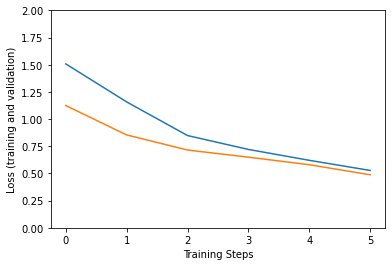

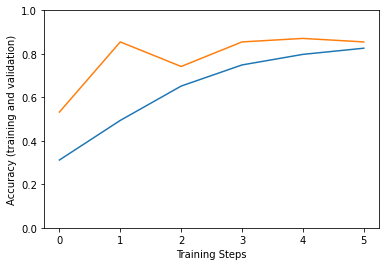

In [ ]:
# Visualize training process

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [ ]:
# Measure accuracy and loss after training

final_loss, final_accuracy = model.evaluate(feature_test, label_test)

4/4 [==============================] - 2s 362ms/step - loss: 0.4440 - acc: 0.8350


In [ ]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 0.44
Final accuracy: 83.50%


### Export your model

We'll save our model as TensorFlow SavedModel format. After that we'll do inference on reloaded model, so if you come with a model already trained, it'll be easier to inspect it.

-- 모델 내보내기

모델을 TensorFlow SavedModel 형식으로 저장합니다. 그 후에 우리는 다시 로드된 모델에 대한 추론을 수행할 것이므로 이미 훈련된 모델과 함께 오는 경우 모델을 검사하기가 더 쉬울 것입니다.

In [ ]:
'''FLOWERS_SAVED_MODEL = "./saved_models/"
tf.saved_model.save(model, FLOWERS_SAVED_MODEL)'''

## Load TensorFlow SavedModel

Let's load TensorFlow model from SavedModel format. Because we used custom layer from TensorFlow Hub, we need to explicitly point out the implementation with `custom_obiects` param.

-TensorFlow 저장된 모델 로드

SavedModel 형식에서 TensorFlow 모델을 로드해 보겠습니다. TensorFlow Hub의 커스텀 레이어를 사용했기 때문에 `custom_obiects` 매개변수로 구현을 명시적으로 지적해야 합니다.

# Load SavedModel(저장된 모델 불러오기)

In [ ]:
'''flowers_model = hub.load(FLOWERS_SAVED_MODEL)
print(flowers_model)'''

## Convert model to TFLite

Convert recently loaded model to TensorFlow Lite models (standard and quantized with a [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization)).

Because of TensorFlow 2.0 nature, we'll need to convert TensorFlow model into concrete function and then do conversion to TFLite. More about it [here](https://www.tensorflow.org/lite/r2/convert/concrete_function).

-모델을 TFLite로 변환

최근에 로드된 모델을 TensorFlow Lite 모델로 변환합니다(표준 및 [훈련 후 양자화](https://www.tensorflow.org/lite/performance/post_training_quantization)로 양자화됨).

TensorFlow 2.0 특성상 TensorFlow 모델을 구체적인 함수로 변환한 다음 TFLite로 변환해야 합니다. [여기](https://www.tensorflow.org/lite/r2/convert/concrete_function)에 대해 자세히 알아보세요.

In [ ]:
'''!mkdir "tflite_models"'''

In [ ]:
'''TFLITE_MODEL = "tflite_models/flowers.tflite"
TFLITE_QUANT_MODEL = "tflite_models/flowers_quant.tflite"'''

# Get the concrete function from the Keras model.(케라스모델로부터 구체적인 함수를 가져와라)

In [ ]:
'''run_model = tf.function(lambda x : flowers_model(x))'''

'run_model = tf.function(lambda x : flowers_model(x))'

# Save the concrete function. (구체적인 함수를 저장하라.)

In [ ]:
'''concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)'''

'concrete_func = run_model.get_concrete_function(\n    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)\n)'

# Convert the model(모델을 바꿔라.)

In [ ]:
'''converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)'''

'converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])\nconverted_tflite_model = converter.convert()\nopen(TFLITE_MODEL, "wb").write(converted_tflite_model)'

# Convert the model to quantized version with post-training quantization
#훈련 후 양자화를 통해 모델을 양자화 버전으로 변환


In [ ]:
'''converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

print("TFLite models and their sizes:")
!ls "tflite_models" -lh'''

### Load TFLite model (TFLite 모델 로드하기)

Load TensorFlow lite model with interpreter interface.(인터프리터 인터페이스로 TensorFlow 라이트 모델을 로드합니다.)

# Load TFLite model and see some details about input/output
#TFLite 모델을 로드하고 입력값/출력값의 세부사항을 살펴라.

In [ ]:
'''tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])''')

#### Resize input and output tensors shapes (입력값과 출력값의 텐서 모양을 바꿔라.)

Input shape of loaded TFLite model is 1x224x224x3, what means that we can make predictions for single image.
Let's resize input and output tensors, so we can make predictions for batch of 32 images.
 (로드된 TFLite 모델의 입력 형태는 1x224x224x3이며, 이는 단일 이미지에 대한 예측을 할 수 있음을 의미합니다.
입력 및 출력 텐서의 크기를 조정하여 32개의 이미지 배치를 예측할 수 있도록 합시다.)


In [ ]:
'''tflite_interpreter.resize_tensor_input(input_details[0]['index'], (1, 224, 224, num_color)) # 32
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (1, num_classes)) # 32
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])'''

'tflite_interpreter.resize_tensor_input(input_details[0][\'index\'], (1, 224, 224, num_color)) # 32\ntflite_interpreter.resize_tensor_input(output_details[0][\'index\'], (1, num_classes)) # 32\ntflite_interpreter.allocate_tensors()\n\ninput_details = tflite_interpreter.get_input_details()\noutput_details = tflite_interpreter.get_output_details()\n\nprint("== Input details ==")\nprint("name:", input_details[0][\'name\'])\nprint("shape:", input_details[0][\'shape\'])\nprint("type:", input_details[0][\'dtype\'])\n\nprint("\n== Output details ==")\nprint("name:", output_details[0][\'name\'])\nprint("shape:", output_details[0][\'shape\'])\nprint("type:", output_details[0][\'dtype\'])'

In [ ]:
'''tflite_interpreter.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter.invoke()

tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)'''

# Convert prediction results to Pandas dataframe, for better visualization
(더 나은 시각화를 위해 예측 결과를 Pandas 데이터 프레임으로 변환)

In [ ]:
'''tflite_pred_dataframe = pd.DataFrame(tflite_model_predictions)
tflite_pred_dataframe.columns = dataset_labels

print("TFLite prediction results for the first elements")
tflite_pred_dataframe.head()'''

'tflite_pred_dataframe = pd.DataFrame(tflite_model_predictions)\ntflite_pred_dataframe.columns = dataset_labels\n\nprint("TFLite prediction results for the first elements")\ntflite_pred_dataframe.head()'

Now let's do the same for TFLite quantized model:
- Load model,
- Reshape input to handle batch of images,
- Run prediction

이제 TFLite 양자화 모델에 대해서도 동일한 작업을 수행해 보겠습니다.
- 로드 모델,
- 이미지 배치를 처리하기 위해 입력 모양 변경,
- 예측 실행

# Load quantized TFLite model(양자화된 TFLite 모델을 로드하라.)

In [ ]:
'''tflite_interpreter_quant = tf.lite.Interpreter(model_path=TFLITE_QUANT_MODEL)'''

'tflite_interpreter_quant = tf.lite.Interpreter(model_path=TFLITE_QUANT_MODEL)'

# Learn about its input and output details(입력값과 출력값의 세부사항을 배워라.)

In [ ]:
'''input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()'''

'input_details = tflite_interpreter_quant.get_input_details()\noutput_details = tflite_interpreter_quant.get_output_details()'

# Resize input and output tensors to handle batch of 32 images(입력값과 출력값의 텐서 모양을 바꿔라. 32장의 이미지 묶음을 처리하기 위해서.)

In [ ]:
'''tflite_interpreter_quant.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter_quant.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter_quant.allocate_tensors()

input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])'''

'tflite_interpreter_quant.resize_tensor_input(input_details[0][\'index\'], (32, 224, 224, 3))\ntflite_interpreter_quant.resize_tensor_input(output_details[0][\'index\'], (32, 5))\ntflite_interpreter_quant.allocate_tensors()\n\ninput_details = tflite_interpreter_quant.get_input_details()\noutput_details = tflite_interpreter_quant.get_output_details()\n\nprint("== Input details ==")\nprint("name:", input_details[0][\'name\'])\nprint("shape:", input_details[0][\'shape\'])\nprint("type:", input_details[0][\'dtype\'])\n\nprint("\n== Output details ==")\nprint("name:", output_details[0][\'name\'])\nprint("shape:", output_details[0][\'shape\'])\nprint("type:", output_details[0][\'dtype\'])'

# Run inference(추론을 실행하라.)

In [ ]:
'''tflite_interpreter_quant.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter_quant.invoke()

tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(output_details[0]['index'])
print("\nPrediction results shape:", tflite_q_model_predictions.shape)
'''

'tflite_interpreter_quant.set_tensor(input_details[0][\'index\'], val_image_batch)\n\ntflite_interpreter_quant.invoke()\n\ntflite_q_model_predictions = tflite_interpreter_quant.get_tensor(output_details[0][\'index\'])\nprint("\nPrediction results shape:", tflite_q_model_predictions.shape)\n'

# Convert prediction results to Pandas dataframe, for better visualization(더 나은 시각화를 위해 예측 결과를 Pandas 데이터 프레임으로 변환)

In [ ]:
'''tflite_q_pred_dataframe = pd.DataFrame(tflite_q_model_predictions)
tflite_q_pred_dataframe.columns = dataset_labels

print("Quantized TFLite model prediction results for the first elements")
tflite_q_pred_dataframe.head()'''

'tflite_q_pred_dataframe = pd.DataFrame(tflite_q_model_predictions)\ntflite_q_pred_dataframe.columns = dataset_labels\n\nprint("Quantized TFLite model prediction results for the first elements")\ntflite_q_pred_dataframe.head()'

## Compare prediction results (예측 결과 비교)

Now we will use Pandas to visualize results from all 3 models and find differences between them.
(이제 Pandas를 사용하여 3가지 모델 모두의 결과를 시각화하고 차이점을 찾습니다.)

# Concatenate results from all models(모든 모델의 결과 연결)

In [ ]:
'''all_models_dataframe = pd.concat([tf_pred_dataframe, 
                                  tflite_pred_dataframe, 
                                  tflite_q_pred_dataframe], 
                                 keys=['TF Model', 'TFLite', 'TFLite quantized'],
                                 axis='columns')
all_models_dataframe.head()'''

"all_models_dataframe = pd.concat([tf_pred_dataframe, \n                                  tflite_pred_dataframe, \n                                  tflite_q_pred_dataframe], \n                                 keys=['TF Model', 'TFLite', 'TFLite quantized'],\n                                 axis='columns')\nall_models_dataframe.head()"

# Swap columns to hava side by side comparison(나란히 비교할 수 있도록 열을 바꿉니다.)

In [ ]:
'''
all_models_dataframe = all_models_dataframe.swaplevel(axis='columns')[tflite_pred_dataframe.columns]
all_models_dataframe.head()'''

# Highlight TFLite models predictions that are different from original model (원래 모델과 다른 TFLite 모델 예측 강조 표시)

In [ ]:
'''def highlight_diff(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    other = data.xs('TF Model', axis='columns', level=-1)
    return pd.DataFrame(np.where(data.ne(other, level=0), attr, ''),
                        index=data.index, columns=data.columns)

all_models_dataframe.style.apply(highlight_diff, axis=None)'''

"def highlight_diff(data, color='yellow'):\n    attr = 'background-color: {}'.format(color)\n    other = data.xs('TF Model', axis='columns', level=-1)\n    return pd.DataFrame(np.where(data.ne(other, level=0), attr, ''),\n                        index=data.index, columns=data.columns)\n\nall_models_dataframe.style.apply(highlight_diff, axis=None)"

As we can see, in most cases predictions are different between all models, usually by small factors. High-confidence predictions between TensorFlow and TensorFlow Lite models are very close to each other (in some cases there are even similar).  
Quantized model outstands the most, but this is the cost of optimizations (model weights 3-4 times less).

우리가 볼 수 있듯이 대부분의 경우 예측은 일반적으로 작은 요인에 의해 모든 모델 간에 다릅니다. TensorFlow와 TensorFlow Lite 모델 간의 높은 신뢰도 예측은 서로 매우 가깝습니다(어떤 경우에는 유사하기도 함).
양자화 모델이 가장 뛰어나지만 최적화 비용입니다(모델 가중치 3~4배 적음).

To make prediction results even more readable, let's simplify dataframes, to show only the highest-score prediction and the corresponding label.

예측 결과를 더 읽기 쉽게 만들기 위해 데이터 프레임을 단순화하여 최고 점수 예측과 해당 레이블만 표시해 보겠습니다.

# Concatenation of argmax and max value for each row(# 각 행에 대한 argmax와 max 값의 연결)

In [ ]:
'''def max_values_only(data):
  argmax_col = np.argmax(data, axis=1).reshape(-1, 1)
  max_col = np.max(data, axis=1).reshape(-1, 1)
  return np.concatenate([argmax_col, max_col], axis=1)'''

'def max_values_only(data):\n  argmax_col = np.argmax(data, axis=1).reshape(-1, 1)\n  max_col = np.max(data, axis=1).reshape(-1, 1)\n  return np.concatenate([argmax_col, max_col], axis=1)'

# Build simplified prediction tables(# 단순화된 예측 테이블 작성)

In [ ]:
'''tf_model_pred_simplified = max_values_only(tf_model_predictions)
tflite_model_pred_simplified = max_values_only(tflite_model_predictions)
tflite_q_model_pred_simplified = max_values_only(tflite_q_model_predictions)'''

'tf_model_pred_simplified = max_values_only(tf_model_predictions)\ntflite_model_pred_simplified = max_values_only(tflite_model_predictions)\ntflite_q_model_pred_simplified = max_values_only(tflite_q_model_predictions)'

# Build DataFrames and present example(# DataFrame을 구축하고 예제를 제시합니다.)

In [ ]:
'''columns_names = ["Label_id", "Confidence"]
tf_model_simple_dataframe = pd.DataFrame(tf_model_pred_simplified)
tf_model_simple_dataframe.columns = columns_names

tflite_model_simple_dataframe = pd.DataFrame(tflite_model_pred_simplified)
tflite_model_simple_dataframe.columns = columns_names

tflite_q_model_simple_dataframe = pd.DataFrame(tflite_q_model_pred_simplified)
tflite_q_model_simple_dataframe.columns = columns_names

tf_model_simple_dataframe.head()'''

'columns_names = ["Label_id", "Confidence"]\ntf_model_simple_dataframe = pd.DataFrame(tf_model_pred_simplified)\ntf_model_simple_dataframe.columns = columns_names\n\ntflite_model_simple_dataframe = pd.DataFrame(tflite_model_pred_simplified)\ntflite_model_simple_dataframe.columns = columns_names\n\ntflite_q_model_simple_dataframe = pd.DataFrame(tflite_q_model_pred_simplified)\ntflite_q_model_simple_dataframe.columns = columns_names\n\ntf_model_simple_dataframe.head()'

# Concatenate results from all models(# 모든 모델의 결과 연결)

In [ ]:
'''all_models_simple_dataframe = pd.concat([tf_model_simple_dataframe, 
                                         tflite_model_simple_dataframe, 
                                         tflite_q_model_simple_dataframe], 
                                        keys=['TF Model', 'TFLite', 'TFLite quantized'],
                                        axis='columns')'''

"all_models_simple_dataframe = pd.concat([tf_model_simple_dataframe, \n                                         tflite_model_simple_dataframe, \n                                         tflite_q_model_simple_dataframe], \n                                        keys=['TF Model', 'TFLite', 'TFLite quantized'],\n                                        axis='columns')"

# Swap columns for side-by-side comparison(# 나란히 비교를 위해 열 교체)

In [ ]:
'''all_models_simple_dataframe = all_models_simple_dataframe.swaplevel(axis='columns')[tf_model_simple_dataframe.columns]'''

"all_models_simple_dataframe = all_models_simple_dataframe.swaplevel(axis='columns')[tf_model_simple_dataframe.columns]"

# Highlight differences(# 차이점 강조)

In [ ]:
'''all_models_simple_dataframe.style.apply(highlight_diff, axis=None)'''

'all_models_simple_dataframe.style.apply(highlight_diff, axis=None)'

## Visualize predictions from TFLite models(FLite 모델의 예측 시각화)

At the end let's visualize predictions from TensorFlow Lite and quantized TensorFlow Lite models.

마지막으로 TensorFlow Lite 및 양자화된 TensorFlow Lite 모델의 예측을 시각화해 보겠습니다.

# Print images batch and labels predictions for TFLite Model(# TFLite 모델에 대한 이미지 배치 및 레이블 예측 출력)

In [ ]:
'''tflite_predicted_ids = np.argmax(tflite_model_predictions, axis=-1)
tflite_predicted_labels = dataset_labels[tflite_predicted_ids]
tflite_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("TFLite model predictions (green: correct, red: incorrect)")'''

'tflite_predicted_ids = np.argmax(tflite_model_predictions, axis=-1)\ntflite_predicted_labels = dataset_labels[tflite_predicted_ids]\ntflite_label_id = np.argmax(val_label_batch, axis=-1)\n\nplt.figure(figsize=(10,9))\nplt.subplots_adjust(hspace=0.5)\nfor n in range(30):\n  plt.subplot(6,5,n+1)\n  plt.imshow(val_image_batch[n])\n  color = "green" if tflite_predicted_ids[n] == true_label_ids[n] else "red"\n  plt.title(tflite_predicted_labels[n].title(), color=color)\n  plt.axis(\'off\')\n_ = plt.suptitle("TFLite model predictions (green: correct, red: incorrect)")'

## Export image validation batch(이미지 유효성 검사 일괄 내보내기)

Export validation batch so it can be tested client side. Below we create compressed file containing all images named with the convention:

`n{}_true{}_pred{}.jpg`

where the first number is index, the second - true label index, the third - value predicted by TFLite moder generated in this notebook. Example file will look similar to this: `n0_true1_pred1.jpg`.

All images then will be put into client side testing code (res/assets in Android tests). Integration tests will run inference process on each image and then compare results with the ones saved in file names.

클라이언트 측에서 테스트할 수 있도록 유효성 검사 일괄 처리를 내보냅니다. 아래에서는 규칙에 따라 이름이 지정된 모든 이미지가 포함된 압축 파일을 만듭니다.

`n{}_true{}_pred{}.jpg`

여기서 첫 번째 숫자는 인덱스, 두 번째는 실제 레이블 인덱스, 세 번째는 이 노트북에서 생성된 TFLite 모더가 예측한 값입니다. 예제 파일은 `n0_true1_pred1.jpg`와 유사합니다.

그러면 모든 이미지가 클라이언트 측 테스트 코드(Android 테스트의 res/assets)에 포함됩니다. 통합 테스트는 각 이미지에 대해 추론 프로세스를 실행한 다음 파일 이름에 저장된 결과와 결과를 비교합니다.

In [ ]:
'''from PIL import Image'''

'from PIL import Image'

In [ ]:
'''VAL_BATCH_DIR = "validation_batch"'''

'VAL_BATCH_DIR = "validation_batch"'

In [ ]:
'''!mkdir {VAL_BATCH_DIR}'''

'!mkdir {VAL_BATCH_DIR}'

# Export batch to *.jpg files with specific naming convention.(# 특정 명명 규칙에 따라 배치를 *.jpg 파일로 내보냅니다.)

# Make sure they are exported in the full quality, otherwise the inference(# 전체 품질로 내보내졌는지 확인하세요. 그렇지 않으면 추론이 가능합니다.)

# process will return different results. (# 프로세스는 다른 결과를 반환합니다.)

In [ ]:
'''for n in range(32):
  filename = "n{:0.0f}_true{:0.0f}_pred{:0.0f}.jpg".format(
      n,
      true_label_ids[n],
      tflite_model_pred_simplified[n][0]
  )
  img_arr = np.copy(val_image_batch[n])
  img_arr *= 255
  img_arr = img_arr.astype("uint8")
  img11 = Image.fromarray(img_arr, 'RGB')
  img11.save("{}/{}".format(VAL_BATCH_DIR, filename), "JPEG", quality=100)'''

In [ ]:
'''!tar -zcvf {VAL_BATCH_DIR}.tar.gz {VAL_BATCH_DIR}'''

File `validation_batch.tar.gz` is ready to be downloaded, unpacked and put into client-side testing code.

`validation_batch.tar.gz` 파일을 다운로드하고 압축을 풀고 클라이언트 측 테스트 코드에 넣을 준비가 되었습니다.